# CNN + GlobalAvgPool 
Based on CNN 107 which got 75% acc on H1 coding len 2000-4000.  
Model: Embed mask, Conv1D, GlobalAvgPool.   

H1 coding len 3000-4000.  
Cross validation 5 folds 5 epochs, accuracy mean , F1 mean 

Same as CNN 118 but switch cell line 1 to 12.   


In [296]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2022-12-29 16:49:50.385188
Python 3.8.16
sklearn 1.0.2


We prevously used sklearn.model_selection.ShuffleSplit   
Now we avoid it due to this note in the 
[documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html):
Note: contrary to other cross-validation strategies, random splits do not guarantee that all folds will be different, although this is still very likely for sizeable datasets.

In [297]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
tf.random.set_seed(42) 

from tensorflow import keras
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import Flatten
from keras.layers import Attention
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
RCI_THRESHOLD=0.0
CFILTERS=64
FILTERSIZE=8
RCELLS=16
DCELLS=8
EPOCHS=5
FOLDS=5      
EMBED_DIMEN = 4 # arbitrary hyperparameter
BREAK = False   # break after first fold
MINLEN=3000
MAXLEN=4000   

In [298]:
try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/'    # Mac
print(DATA_DIR)

Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/


In [299]:
GENES_FILE =    'CNRCI_coding_train_genes.csv'
RCI_FILE =      'CNRCI_coding_train_RCI.gc42.csv'
SEQUENCE_FILE = 'CNRCI_coding_train_transcripts.gc42.csv'
COUNTS_FILE=    'CNRCI_coding_train_counts.K4.gc42.csv'

In [300]:
def get_ordered_list():
    ordered_list = \
    ['A549',\
      'H1.hESC',\
      'HeLa.S3',\
      'HepG2',\
      'HT1080',\
      'HUVEC',\
      'MCF.7',\
      'NCI.H460',\
      'NHEK',\
      'SK.MEL.5',\
      'SK.N.DZ',\
      'SK.N.SH',\
      'GM12878',\
      'K562',\
      'IMR.90']
    return ordered_list
CELL_LINE_NUMBER=12

all_cell_lines = get_ordered_list()
cell_line_name = all_cell_lines[CELL_LINE_NUMBER]
print('Cell line for today:',CELL_LINE_NUMBER,'=',cell_line_name)

Cell line for today: 12 = GM12878


## Data Load

In [301]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        
    def load_gene_rci_values(self,filepath,cell_line):
        '''
        Load from RCI csv file.
        Return dict with keys=gene:str and values=RCI:float.
        '''
        gene_to_rci = {}
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields[0]
                    rci_val = fields[cell_line+1]
                    if rci_val != "nan":
                        # Convert string nan to float(nan)
                        gene_to_rci[gene_id] = float(rci_val)
        return gene_to_rci
    
    def seq_to_kmer_values(self,rna,K):
        # The cache may represent more than one K. Probably not a problem.
        N_indicator = 0 # indicator value
        vec=[] # seq converted to list of K-mers 
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def rci_to_label(self,rci):
        CYTO_LABEL = 1
        NUCLEAR_LABEL = 0
        # cnrci = log (cyto-to-nuclear ratio)
        # rci > 0 implies cytoplasmic
        if rci > RCI_THRESHOLD:
            return CYTO_LABEL
        return NUCLEAR_LABEL

    def load_sequence(self,filepath):
        labels=[]
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # with version number
                    gene_id = fields[1]        # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    if seq_len>=MINLEN and seq_len<=MAXLEN and gene_id in gene_to_rci.keys():
                        allids.append( (gene_id,tran_id) )
                        rci_val = gene_to_rci[gene_id]
                        rci_label = self.rci_to_label(rci_val)
                        labels.append(rci_label)
                        if seq_len<MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                            seq_txt = seq_txt[:MAXLEN]
                        hot_vec = self.seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        return labels,allids,allseq
    
loader = DataLoader()
# test it
print(loader.seq_to_kmer_values('AAAA',3))
print(loader.seq_to_kmer_values('CATT',3))
print(loader.seq_to_kmer_values('TTGA',3))
print(loader.seq_to_kmer_values('TTTN',3))
# test it
print(loader.rci_to_label(-0.9))
print(loader.rci_to_label(1.1))

[1, 1]
[20, 16]
[63, 57]
[64, 0]
0
1


In [302]:
print(datetime.now())
print("Load RCI values...")
loader = DataLoader()
filepath = DATA_DIR+RCI_FILE
gene_to_rci = loader.load_gene_rci_values(filepath,CELL_LINE_NUMBER)
print('Num RCI:', len(gene_to_rci.keys()))
print('Example RCI:', list(gene_to_rci.items())[:3])
print("Load genes...")
all_genes = list(gene_to_rci.keys())
print(datetime.now())
print('Load sequence...')
filepath = DATA_DIR+SEQUENCE_FILE
labels,allids,allseq = loader.load_sequence(filepath)
print(datetime.now())
print('Num IDs:',len(allids))
print('Example IDs:',[allids[x] for x in [10, 20, 30, 40]] )
print('Count',np.count_nonzero(labels),'ones out of',len(labels),'labels.')
print('Example labels:',[labels[x] for x in [10, 20, 30, 40]] )
print('Num counts:',len(allseq))
print('Example sequence:',allseq[3])
loader = None  # drop K-mer cache to save RAM

2022-12-29 16:49:53.090162
Load RCI values...
Num RCI: 9931
Example RCI: [('ENSG00000000419', 0.43903), ('ENSG00000000457', -0.561655), ('ENSG00000000460', -1.59769)]
Load genes...
2022-12-29 16:49:53.123794
Load sequence...
2022-12-29 16:50:02.252421
Num IDs: 5577
Example IDs: [('ENSG00000116198', 'ENST00000461667.2'), ('ENSG00000171680', 'ENST00000377728.8'), ('ENSG00000171621', 'ENST00000328089.11'), ('ENSG00000028137', 'ENST00000376259.7')]
Count 2081 ones out of 5577 labels.
Example labels: [0, 0, 1, 1]
Num counts: 5577
Example sequence: [126, 245, 212, 79, 57, 228, 144, 61, 241, 194, 8, 30, 118, 214, 86, 85, 81, 67, 11, 44, 174, 182, 216, 95, 122, 229, 148, 77, 52, 208, 64, 256, 254, 248, 222, 117, 209, 68, 15, 59, 235, 170, 166, 149, 82, 70, 23, 90, 103, 154, 102, 150, 87, 91, 106, 166, 149, 83, 73, 33, 131, 9, 36, 144, 64, 256, 256, 253, 244, 207, 59, 236, 173, 177, 193, 1, 4, 16, 64, 256, 255, 252, 239, 185, 228, 143, 59, 235, 169, 161, 129, 1, 2, 8, 30, 117, 212, 78, 54, 214,

## Model

In [303]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    rnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    #rnn1_layer = Bidirectional( LSTM(RCELLS, return_sequences=False) )
    #pool_layer = MaxPooling1D(pool_size=3)
    pool_layer = GlobalAveragePooling1D()
    #pool_layer = GlobalMaxPooling1D()
    flat_layer = Flatten()
    den1_layer = Dense(DCELLS)
    drop_layer = Dropout(0.5)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    rnn.add(embed_layer)
    rnn.add(cnn1_layer)
    rnn.add(pool_layer)
    #rnn.add(flat_layer)
    #rnn.add(den1_layer)
    #rnn.add(drop_layer)
    rnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    print("COMPILE")
    rnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return rnn

In [304]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once

2022-12-29 16:50:02.285666
COMPILE
Model: "sequential_154"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_154 (Embedding)   (None, 3997, 4)           1028      
                                                                 
 conv1d_154 (Conv1D)         (None, 3990, 64)          2112      
                                                                 
 global_average_pooling1d_14  (None, 64)               0         
 1 (GlobalAveragePooling1D)                                      
                                                                 
 dense_307 (Dense)           (None, 1)                 65        
                                                                 
Total params: 3,205
Trainable params: 3,205
Non-trainable params: 0
_________________________________________________________________
None


## Training

In [305]:
class CrossValidator():
    def __init__(self,epochs,folds,quick_test=False,pred_threshold=0.5):
        self.epochs = epochs
        self.folds = folds
        self.quick_test = quick_test
        self.threshold = pred_threshold # e.g. score>0.5 => class 1
    
    def get_gene_subset(self,all_genes,sub_index):
        sub_genes = set()
        for index in sub_index:
            one_gene = all_genes[index]
            sub_genes.add(one_gene)
        return sub_genes
    
    def get_X_y(self,gene_set,allids,allX,allY):
        cnt = len(allids)
        subsetX=[]
        subsetY=[]
        if cnt != len(allX) or cnt!= len(allY):
            raise Exception('Lengths differ')
        for i in range(cnt):
            gene_id,tran_id = allids[i]
            if gene_id in gene_set:
                oneX = allX[i]
                oneY = allY[i]
                subsetX.append(oneX)
                subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def do_cross_validation(self):
        cv_accuracy=[]
        cv_precision=[]
        cv_recall=[]
        cv_f1=[]
        fold=0
        print(datetime.now())
        print('splitting')
        # KFold shuffles once before making the partitions
        splitter = KFold(n_splits=self.folds,shuffle=True,random_state=42)
        for train_index,valid_index in splitter.split(all_genes):
            fold += 1
            print('Fold',fold)
            train_genes = self.get_gene_subset(all_genes,train_index)
            valid_genes = self.get_gene_subset(all_genes,valid_index)
            X_train,y_train = self.get_X_y(train_genes,allids,allseq,labels)
            X_valid,y_valid = self.get_X_y(valid_genes,allids,allseq,labels)

            print('Training example')
            print(X_train[0])

            print('Train sizes',X_train.shape,y_train.shape)
            print('Valid sizes',X_valid.shape,y_valid.shape)
            print('Train set ones/size',
                  np.count_nonzero(y_train),'/',len(y_train))
            print('Valid set ones/size',
                  np.count_nonzero(y_valid),'/',len(y_valid))

            print("BUILD MODEL")
            model=build_model()

            print("FIT")
            print(datetime.now())
            history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                    epochs=self.epochs, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                    validation_data=(X_valid,y_valid) )

            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()

            print("Compute valiation accuracy")
            print(datetime.now())
            yhat_pred=model.predict(X_valid, verbose=0) 
            print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
            yhat_classes=np.where(yhat_pred > self.threshold, 1, 0)
            print('Predicted zeros and ones',np.count_nonzero(yhat_classes==0),np.count_nonzero(yhat_classes==1))
            # accuracy: (tp + tn) / (p + n)
            accuracy = accuracy_score(y_valid, yhat_classes)*100.
            # precision tp / (tp + fp)
            precision = precision_score(y_valid, yhat_classes)*100.
            # recall: tp / (tp + fn)
            recall = recall_score(y_valid, yhat_classes)*100.
            # f1: 2 tp / (2 tp + fp + fn)
            f1 = f1_score(y_valid, yhat_classes)*100.
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%% F1: %.2f%%' % (accuracy,precision,recall,f1)) 
            print(datetime.now())
            cv_accuracy.append(accuracy)
            cv_precision.append(precision)
            cv_recall.append(recall)
            cv_f1.append(f1)
            if self.quick_test:   
                print('Break -- this was for code testing only')
                break
        print()
        return cv_accuracy, cv_precision, cv_recall, cv_f1

2022-12-29 16:50:02.547992
2022-12-29 16:50:02.548159
splitting
Fold 1
Training example
[ 62 246 215 ...   0   0   0]
Train sizes (4423, 3997) (4423, 1)
Valid sizes (1154, 3997) (1154, 1)
Train set ones/size 1712 / 4423
Valid set ones/size 369 / 1154
BUILD MODEL
COMPILE
FIT
2022-12-29 16:50:03.926372
Epoch 1/5
139/139 [==============================] - 2s 9ms/step - loss: 0.6561 - accuracy: 0.6100 - val_loss: 0.6214 - val_accuracy: 0.6742
Epoch 2/5
139/139 [==============================] - 1s 7ms/step - loss: 0.6313 - accuracy: 0.6055 - val_loss: 0.6164 - val_accuracy: 0.6794
Epoch 3/5
139/139 [==============================] - 1s 7ms/step - loss: 0.6233 - accuracy: 0.6213 - val_loss: 0.6041 - val_accuracy: 0.6837
Epoch 4/5
139/139 [==============================] - 1s 7ms/step - loss: 0.6181 - accuracy: 0.6367 - val_loss: 0.5931 - val_accuracy: 0.6958
Epoch 5/5
139/139 [==============================] - 1s 7ms/step - loss: 0.6090 - accuracy: 0.6543 - val_loss: 0.5822 - val_accuracy: 

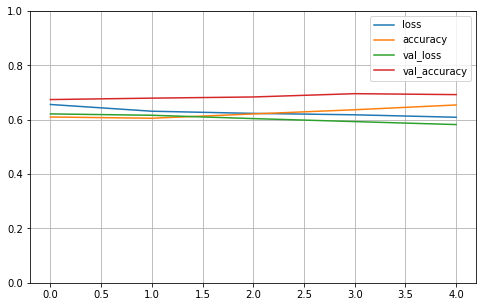

Compute valiation accuracy
2022-12-29 16:50:14.963374
Range of scores: 0.04529693 to 0.6970808
Predicted zeros and ones 1028 126
Accuracy: 69.24% Precision: 55.56% Recall: 18.97% F1: 28.28%
2022-12-29 16:50:15.170198
Fold 2
Training example
[ 62 246 215 ...   0   0   0]
Train sizes (4373, 3997) (4373, 1)
Valid sizes (1204, 3997) (1204, 1)
Train set ones/size 1619 / 4373
Valid set ones/size 462 / 1204
BUILD MODEL
COMPILE
FIT
2022-12-29 16:50:16.496159
Epoch 1/5
137/137 [==============================] - 2s 9ms/step - loss: 0.6552 - accuracy: 0.6295 - val_loss: 0.6460 - val_accuracy: 0.6163
Epoch 2/5
137/137 [==============================] - 1s 7ms/step - loss: 0.6283 - accuracy: 0.6286 - val_loss: 0.6336 - val_accuracy: 0.6063
Epoch 3/5
137/137 [==============================] - 1s 7ms/step - loss: 0.6186 - accuracy: 0.6325 - val_loss: 0.6290 - val_accuracy: 0.6246
Epoch 4/5
137/137 [==============================] - 1s 7ms/step - loss: 0.6109 - accuracy: 0.6499 - val_loss: 0.6276 - va

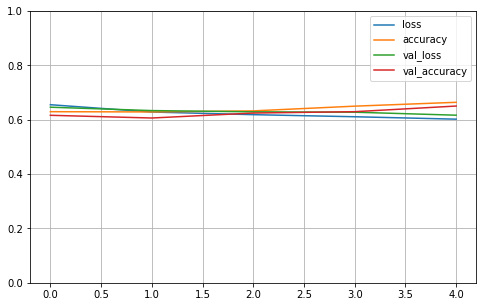

Compute valiation accuracy
2022-12-29 16:50:27.514191
Range of scores: 0.056208488 to 0.8075347
Predicted zeros and ones 897 307
Accuracy: 65.03% Precision: 56.68% Recall: 37.66% F1: 45.25%
2022-12-29 16:50:27.762229
Fold 3
Training example
[ 62 246 215 ...   0   0   0]
Train sizes (4483, 3997) (4483, 1)
Valid sizes (1094, 3997) (1094, 1)
Train set ones/size 1649 / 4483
Valid set ones/size 432 / 1094
BUILD MODEL
COMPILE
FIT
2022-12-29 16:50:29.090230
Epoch 1/5
141/141 [==============================] - 2s 9ms/step - loss: 0.6535 - accuracy: 0.6319 - val_loss: 0.6443 - val_accuracy: 0.6079
Epoch 2/5
141/141 [==============================] - 1s 7ms/step - loss: 0.6296 - accuracy: 0.6337 - val_loss: 0.6275 - val_accuracy: 0.6179
Epoch 3/5
141/141 [==============================] - 1s 7ms/step - loss: 0.6204 - accuracy: 0.6391 - val_loss: 0.6169 - val_accuracy: 0.6152
Epoch 4/5
141/141 [==============================] - 1s 7ms/step - loss: 0.6119 - accuracy: 0.6480 - val_loss: 0.6079 - va

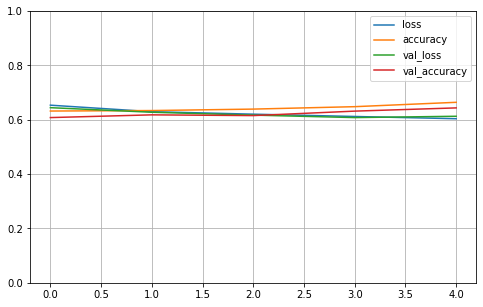

Compute valiation accuracy
2022-12-29 16:50:40.082876
Range of scores: 0.04920515 to 0.7083902
Predicted zeros and ones 994 100
Accuracy: 64.35% Precision: 71.00% Recall: 16.44% F1: 26.69%
2022-12-29 16:50:40.340491
Fold 4
Training example
[126 245 212 ...   0   0   0]
Train sizes (4453, 3997) (4453, 1)
Valid sizes (1124, 3997) (1124, 1)
Train set ones/size 1623 / 4453
Valid set ones/size 458 / 1124
BUILD MODEL
COMPILE
FIT
2022-12-29 16:50:41.682850
Epoch 1/5
140/140 [==============================] - 2s 9ms/step - loss: 0.6560 - accuracy: 0.6337 - val_loss: 0.6567 - val_accuracy: 0.5925
Epoch 2/5
140/140 [==============================] - 1s 7ms/step - loss: 0.6271 - accuracy: 0.6396 - val_loss: 0.6499 - val_accuracy: 0.6085
Epoch 3/5
140/140 [==============================] - 1s 7ms/step - loss: 0.6191 - accuracy: 0.6409 - val_loss: 0.6314 - val_accuracy: 0.6094
Epoch 4/5
140/140 [==============================] - 1s 7ms/step - loss: 0.6098 - accuracy: 0.6481 - val_loss: 0.6183 - val

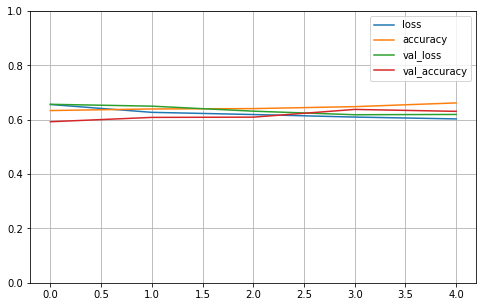

Compute valiation accuracy
2022-12-29 16:50:52.691308
Range of scores: 0.069701366 to 0.76616204
Predicted zeros and ones 945 179
Accuracy: 63.08% Precision: 62.01% Recall: 24.24% F1: 34.85%
2022-12-29 16:50:52.901642
Fold 5
Training example
[ 62 246 215 ...   0   0   0]
Train sizes (4576, 3997) (4576, 1)
Valid sizes (1001, 3997) (1001, 1)
Train set ones/size 1721 / 4576
Valid set ones/size 360 / 1001
BUILD MODEL
COMPILE
FIT
2022-12-29 16:50:54.246636
Epoch 1/5
143/143 [==============================] - 2s 9ms/step - loss: 0.6580 - accuracy: 0.6154 - val_loss: 0.6372 - val_accuracy: 0.6314
Epoch 2/5
143/143 [==============================] - 1s 7ms/step - loss: 0.6287 - accuracy: 0.6259 - val_loss: 0.6253 - val_accuracy: 0.6324
Epoch 3/5
143/143 [==============================] - 1s 7ms/step - loss: 0.6193 - accuracy: 0.6447 - val_loss: 0.6206 - val_accuracy: 0.6394
Epoch 4/5
143/143 [==============================] - 1s 7ms/step - loss: 0.6090 - accuracy: 0.6536 - val_loss: 0.6143 - v

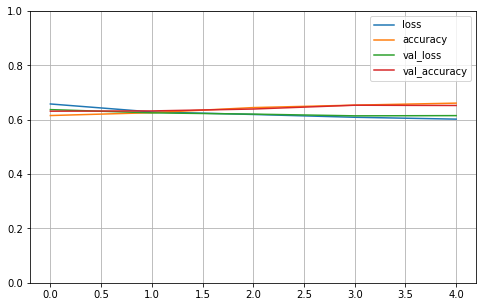

Compute valiation accuracy
2022-12-29 16:51:00.171985
Range of scores: 0.051524594 to 0.8062701
Predicted zeros and ones 719 282
Accuracy: 65.23% Precision: 52.13% Recall: 40.83% F1: 45.79%
2022-12-29 16:51:00.428778

Cross validation 5 folds 5 epochs
 accuracy mean 65.39% +/- 2.07
 precision mean 59.47% +/- 6.58
 recall mean 27.63% +/- 9.87
 F1 mean 36.17% +/- 8.11
2022-12-29 16:51:00.431149


In [306]:
print(datetime.now())
cvdo = CrossValidator(EPOCHS,FOLDS,BREAK)
cv_accuracy, cv_precision, cv_recall, cv_f1 = cvdo.do_cross_validation()   
print("Cross validation %d folds %d epochs" % (FOLDS,EPOCHS)) 
print(" accuracy mean %.2f%% +/- %.2f" % (np.mean(cv_accuracy), np.std(cv_accuracy)))
print(" precision mean %.2f%% +/- %.2f" % (np.mean(cv_precision), np.std(cv_precision)))
print(" recall mean %.2f%% +/- %.2f" % (np.mean(cv_recall), np.std(cv_recall)))
print(" F1 mean %.2f%% +/- %.2f" % (np.mean(cv_f1), np.std(cv_f1)))
print(datetime.now())